An intracranial aneurysm (IA) is a weakened or thinned portion of a blood vessel in the brain that bulges dangerously and fills up with blood. Bloated aneurysms compress the surrounding nerves and brain tissue, and have a high risk of rupture. The risk of such rupture is related to the size and form of the A: The exact shape of aneurysms is critical in medical diagnosis and surgical planning. 

 In current practice, this process requires manual identification by medical experts, taking several minutes per case. Clearly, automating this process is a very worthwhile venture. Furthermore, employing automation, we can also obtain large segmented datasets, which can open up new avenues for research aimed at gaining further insights into IA through statistical analysis. 
Over the last decade, many extraction algorithms have been designed by calculating local geometric features; however, rule-based methods have high computational costs and time requirements, and their performance is limited because of the wide variety of aneurysm shapes. 

Meanwhile, deep learning techniques are becoming increasingly popular in medical image processing. One way to segment 3D dataset is just by looking at one 2d Slice at a time, training a 2D unet, predicting each 2d slice and combine the volume together, which works fine in most cases, but not be the ideal choice for a lot of 3D data set because we probably need information from the few planes below and above. Our proposed model takes a surface model of an entire set of principal brain arteries containing aneurysms as input and returns aneurysm surfaces as output.

The main challenge is the low number of training data, to teach the network, and the complexity and size of the data we have (storage problem). the input images are 192 by 192 by 64, we cannot load all of that into the memory. We will divide these into patches of 64 by 64 by 64, we train the model on these patches, we load the next volume , then train the model then so on.


# Library Inputs

In [ ]:
%%capture
#Dowload some libraries
!pip install classification-models-3D
!pip install efficientnet-3D
!pip install segmentation-models-3D
!pip install patchify

In [ ]:
# import libraries
import h5py
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from patchify import patchify, unpatchify
from matplotlib import pyplot as plt
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, RMSprop, Adagrad, Adadelta, Adam
import segmentation_models_3D as sm
import scipy as sp

Segmentation Models: using `tf.keras` framework.


In [ ]:
#Make sure the GPU is available. 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Load Data

In [ ]:
# select the directory of the folder "Challenge" which contains the data
!cp -a "/content/drive/My Drive/Challenge/challenge_dataset/" "challenge_dataset/"

cp: cannot stat '/content/drive/My Drive/Challenge/challenge_dataset/': No such file or directory


In [ ]:
#Load data with h5 format
Aneurisma_data_list = []
Aneurisma_label_list = []
Aneurisma_overlay_list = []

for i in range(1,104):
  Aneurisma_overlay_temp = []
  f = h5py.File('challenge_dataset/scan_'+str(i)+'.h5', 'r')
  dset = f['raw']
  dset_label = f['label']
  data = np.array(dset[:,:,:])
  data_label = np.array(dset_label[:,:,:])
  Aneurisma_data_list.append(data)
  Aneurisma_label_list.append(data_label)

In [ ]:
#Reshape data (N, x, y, z)
Aneurisma_data = np.array(Aneurisma_data_list).transpose(0,2,3,1)
Aneurisma_label = np.array(Aneurisma_label_list).transpose(0,2,3,1)
print(Aneurisma_data.shape,Aneurisma_label.shape)

In [ ]:
# save some storage 
del f
del dset
del dset_label
del data_label
del data
del Aneurisma_data_list
del Aneurisma_label_list

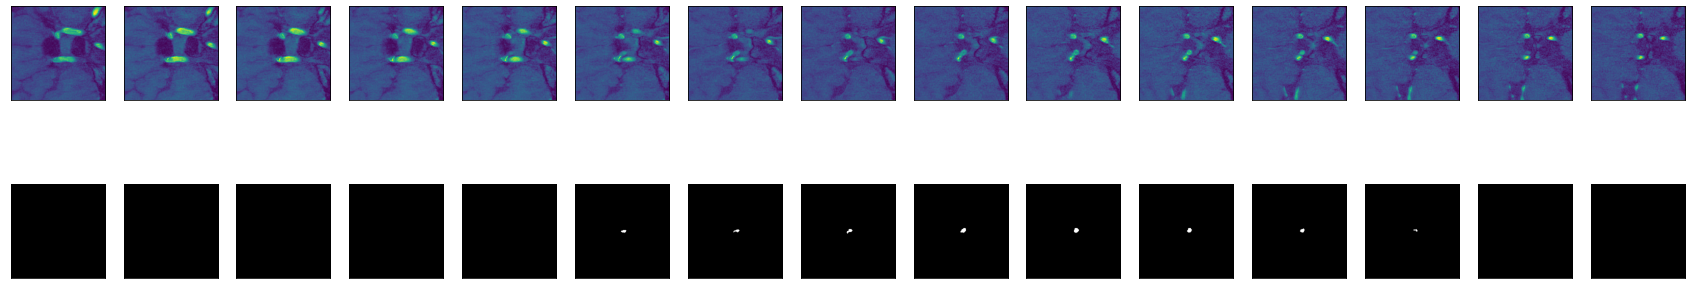

In [ ]:
# The data is displayed as sequential data sets 3D MRI data, 15 sequential slices of a 3D image
n = 15
plt.figure(figsize=(30, 6))
for i in range(24, n+24):
    # display original
    img_data = Aneurisma_data[13][:,:,i]
    img_label = Aneurisma_label[13][:,:,i]
    ax = plt.subplot(2, n, i-23)
    plt.imshow(img_data)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display labels
    ax = plt.subplot(2, n, i-23  + n)
    plt.imshow(img_label,cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Unet Model Transfer Learning

In [ ]:
# Refernce
# @article{solovyev20223d,
#   title={3D convolutional neural networks for stalled brain capillary detection},
#   author={Solovyev, Roman and Kalinin, Alexandr A and Gabruseva, Tatiana},
#   journal={Computers in Biology and Medicine},
#   volume={141},
#   pages={105089},
#   year={2022},
#   publisher={Elsevier},
#   doi={10.1016/j.compbiomed.2021.105089}
# }
# https://github.com/ZFTurbo/segmentation_models_3D
# HeadXNet is a CNN with an encoder-decoder structure, where the encoder maps a volume to an abstract low-resolution encoding, 
# and the decoder expands this encoding to a full-resolution segmentation volume.
#Define parametrs for our model
# backbones have pre-trained weights for faster and better convergence

import keras
encoder_weights = 'imagenet'
BACKBONE = 'resnet50'  #Try vgg16, efficientnetb7, inceptionv3, resnet50
activation = 'sigmoid' #because number of class is 1
patch_size = 64
n_classes = 1
channels=3
LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Offline Data augmentation

In [ ]:
#Offline augmentation can dramatically increase the size of the dataset. Since we have problems in RAM storage, only flipping left-right of images is done 
#However Online Augmentation is done after when training the Model
Aneurisma_data = np.append( Aneurisma_data, [ np.fliplr(x) for x in Aneurisma_data], axis=0 )
Aneurisma_label = np.append( Aneurisma_label, [ np.fliplr(y) for y in Aneurisma_label], axis=0 )

# 3D Patch-wise segmentation models

In [ ]:
# The resolution of input 3D data is the primary reason behind the need for large memory and higher
#  computation complexity in training a 3D CNN segmentation model. However, this could be circumvented with a patch-based approach. 
# In patch-wise approach, the input 3D images are converted to small 3D sub-samples and analyzed individually.
# Finally, the patch-wise prediction outcomes will be merged to create the final 3D prediction map.
# The methodology uses cropped 3D patches of size (64 × 64× 64)
# The patch-based segmentation helps to reduce the hardware resources for training and generates
#  a large number of data samples that favor adequate learning. However, the patch-wise analysis often
#  fails to extract global features from the actual image volumes. This may limit the learning performance
#  when the abnormality is region-specific.

img_patches=[]
lbl_patches=[]
for i in range(Aneurisma_data.shape[0]):
  img_patche = patchify(Aneurisma_data[i], (64, 64, 64), step=64) 
  img_patche = np.reshape(img_patche, (-1, img_patche.shape[3], img_patche.shape[4], img_patche.shape[5]))
  img_patche = np.stack((img_patche,)*3, axis=-1)

  lbl_patche = patchify(Aneurisma_label[i], (64, 64, 64), step=64) 
  lbl_patche = np.reshape(lbl_patche, (-1, lbl_patche.shape[3], lbl_patche.shape[4], lbl_patche.shape[5]))
  lbl_patche = np.expand_dims(lbl_patche, axis=4)

  img_patches.append(img_patche)
  lbl_patches.append(lbl_patche)
img_patches = np.array(img_patches)
lbl_patches = np.array(lbl_patches)

In [ ]:
#Reshape dataset (N,x,y,z,C)
img_patches1 = np.reshape(img_patches, (-1, img_patches.shape[2], img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
lbl_patches1 = np.reshape(lbl_patches, (-1, lbl_patches.shape[2], lbl_patches.shape[3], lbl_patches.shape[4], lbl_patches.shape[5]))

In [ ]:
#Randomly eliminate some patches that do not contain an aneurysm at all, To balance the number of training samples with and without aneurysms
#Many of these patches remain in the data because they are considered useful for knowing when there is an aneurysm and when there is not. 
lbl_patches2 =[]
img_patches2 = []
j=[]
perc=0.1
for i in range(lbl_patches1.shape[0]):
  if len(np.unique(np.squeeze(lbl_patches1[i])))>1:
 #  or np.random.random()<perc:
    img_patches2.append(img_patches1[i])
    lbl_patches2.append(lbl_patches1[i])
    j.append(i)
img_patches1 = np.array(img_patches2)
lbl_patches1 = np.array(lbl_patches2)

In [ ]:
#split the data into training set and validation set 25%
X_train, X_test, y_train, y_test = train_test_split(img_patches1, lbl_patches1,  test_size = 0.3, random_state = 0)

In [ ]:
# pre-process the images if you're using imagenet weights with the backbone - otherwise you end up with garbage resutls 
# and potentially model that does not converge.
preprocess_input = sm.get_preprocessing(BACKBONE)
X_train_prep = preprocess_input(X_train)
X_test_prep = preprocess_input(X_test)

In [ ]:
# save some storage 
del img_patches
del lbl_patches
del img_patches1
del lbl_patches1
del img_patches2
del lbl_patches2
del X_train
del X_test

# Custom ImageDataGenerator

In [ ]:
# This amount of data and its size (3D) is not possible to hold into memory so we will be using a generator method that will yield batches. 
# When encountering a problem where the dataset used is too big to be loaded into memory at once that is being run on RAM. 
# For example, we won’t be able to load all those images into memory before training.
# So, if we create a data generator, we can read images on the go when they will be used for training.
# Since we are reading the images on the go, we are saving memory.

def imageLoader(img_list, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:
        #Shuffle data at every epoch
        batch_start = 0
        batch_end = batch_size
        zip1=list(zip(img_list, mask_list))
        random.shuffle(zip1)
        img_list, mask_list=zip(*zip1)
        while batch_start < L:
            limit = min(batch_end, L)
            X = img_list[batch_start:limit]
            Y = mask_list[batch_start:limit]

            #Randomly apply Online data augmentation, where the images from training data are taken at random and the data augmentation techniques are applied. 
            #The model is then trained based on the original data and the data where the images are randomly augmented.

            if np.random.random() < 0.5:
              to_append_X1 = [ np.flipud(x) for x in X]
              to_append_Y1 = [np.flipud(y) for y in Y]
            # if np.random.random() < 0.5:
            else:
              to_append_X1 = [ np.rot90(x) for x in X]
              to_append_Y1 = [np.rot90(y) for y in Y]
            if np.random.random() < 0.5:
              angle = np.random.uniform(-10,10) + np.random.choice([0,90,180,270]) # To avoid big black areas
              to_append_X2 = [ sp.ndimage.rotate(x,angle,(0,1), reshape=False) for x in X]
              to_append_Y2 = [ sp.ndimage.rotate(y,angle,(0,1), reshape=False) for y in Y]
              # rotations = np.random.randint(0,4, size = 3 )*90
            # rotated_X =  [ sp.ndimage.rotate(sp.ndimage.rotate(sp.ndimage.rotate(x,rotations[0],(0,1), reshape=False),rotations[1],(0,2), reshape=False),rotations[2],(1,2), reshape=False) for x in X]
            else:
              to_append_X2 = [np.einsum('ijkl->ikjl',x) for x in X]
              # rotated_Y =  [ sp.ndimage.rotate(sp.ndimage.rotate(sp.ndimage.rotate(y,rotations[0],(0,1), reshape=False),rotations[1],(0,2), reshape=False),rotations[2],(1,2), reshape=False) for y in Y]
              to_append_Y2 = [np.einsum('ijkl->ikjl',y) for y in Y]
            X = np.concatenate( (X, to_append_X1, to_append_X2), axis=0 )
            Y = np.concatenate( (Y, to_append_Y1, to_append_Y2), axis=0 )
            Aneurisma_data = X
            Aneurisma_label = Y


            yield (Aneurisma_data.astype(np.float32),Aneurisma_label.astype(np.float32)) 

            batch_start += batch_size   
            batch_end += batch_size

In [ ]:
#define the generators
num_train_imgs = len(X_train_prep)
batch_size = 8

train_img_datagen = imageLoader(X_train_prep, 
                                 y_train, batch_size)

val_img_datagen = imageLoader(X_test_prep, 
                                y_test, batch_size)
steps_per_epoch = num_train_imgs //batch_size

# Model

In [ ]:
# Loss Function and metrics to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return 1-jacard_coef(y_true, y_pred)

In [ ]:
#Let's try the two losses and compare the results
total_loss1 = sm.losses.binary_focal_dice_loss # helpful in dealing with class imbalance
total_loss2 = dice_coefficient_loss
total_loss3 = jacard_coef_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
metrics = [sm.metrics.IOUScore(threshold=0.5)]

In [ ]:
# model with another backbone efficientnetb7
model3 = sm.Unet(BACKBONE, classes=n_classes, 
                input_shape=(patch_size, patch_size, patch_size, channels), 
                encoder_weights=encoder_weights,
                activation=activation)

model3.compile(optimizer = optim, loss=total_loss2, metrics=metrics)

In [ ]:

# ModelCheckpoint saves a model or weights (in a checkpoint file) at some interval
checkpoint_filepath1 = '/content/drive/My Drive/Challenge/challenge_dataset/saved_models/modelWeights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath1,
    save_weights_only=True,
    monitor='val_iou_score',
    mode='max',
    save_best_only=True, verbose=1)
history3=model3.fit(train_img_datagen, 
                  steps_per_epoch=steps_per_epoch, 
                  verbose=1, epochs=40,
                  callbacks=[model_checkpoint_callback],
                   validation_data=val_img_datagen,
                   validation_steps=len(X_test_prep)//(batch_size)
                )

Epoch 1/40
24/24 [==============================] - ETA: 0s - loss: 0.9947 - iou_score: 0.0043
Epoch 1: val_iou_score improved from -inf to 0.00233, saving model to /content/drive/My Drive/Challenge/challenge_dataset/saved_models/modelWeights.h5
24/24 [==============================] - 112s 3s/step - loss: 0.9947 - iou_score: 0.0043 - val_loss: 0.9945 - val_iou_score: 0.0023
Epoch 2/40
24/24 [==============================] - ETA: 0s - loss: 0.9920 - iou_score: 0.0140
Epoch 2: val_iou_score improved from 0.00233 to 0.01159, saving model to /content/drive/My Drive/Challenge/challenge_dataset/saved_models/modelWeights.h5
24/24 [==============================] - 67s 3s/step - loss: 0.9920 - iou_score: 0.0140 - val_loss: 0.9932 - val_iou_score: 0.0116
Epoch 3/40
24/24 [==============================] - ETA: 0s - loss: 0.9885 - iou_score: 0.0242
Epoch 3: val_iou_score improved from 0.01159 to 0.02873, saving model to /content/drive/My Drive/Challenge/challenge_dataset/saved_models/modelWeig

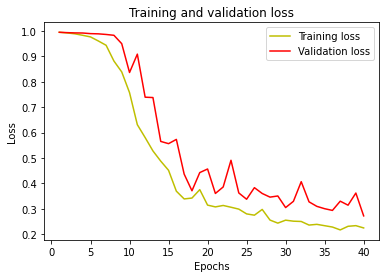

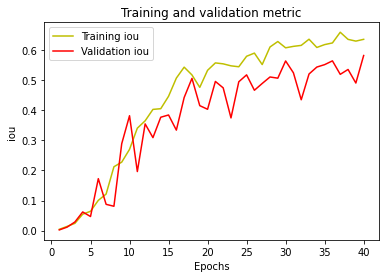

KeyError: ignored

In [ ]:
###
#plot the training and validation IoU and loss at each epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history3.history['iou_score']
val_acc = history3.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training iou')
plt.plot(epochs, val_acc, 'r', label='Validation iou')
plt.title('Training and validation metric')
plt.xlabel('Epochs')
plt.ylabel('iou')
plt.legend()
plt.show()

acc = history3.history['f1-score']
val_acc = history3.history['val_f1-score']

plt.plot(epochs, acc, 'y', label='Training f1-score')
plt.plot(epochs, val_acc, 'r', label='Validation val_f1-score')
plt.title('Training and validation metric')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.show()

In [ ]:
#Fit the model with loss2

history4=model4.fit(train_img_datagen, 
                  steps_per_epoch=steps_per_epoch, 
                  verbose=1, epochs=30,
                   validation_data=val_img_datagen,
                   validation_steps=len(X_test_prep)//(batch_size)
                )

In [ ]:
###
#plot the training and validation IoU and loss at each epoch
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history4.history['dice_coefficient']
val_acc = history4.history['val_dice_coefficient']

plt.plot(epochs, acc, 'y', label='Training metric')
plt.plot(epochs, val_acc, 'r', label='Validation metric')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
#Save model for future use
# model1.save('/content/drive/My Drive/IDSC/Challenge/challenge_dataset/saved_models/model1.h5')
# model2.save('/content/drive/My Drive/IDSC/Challenge/challenge_dataset/saved_models/model2.h5')
model3.save('/content/drive/My Drive/IDSC/Challenge/challenge_dataset/saved_models/OurBestModel.h5')
# model4.save('/content/drive/My Drive/IDSC/Challenge/challenge_dataset/saved_models/model4.h5')

In [ ]:
#Load the pretrained model for testing and prediction
my_model = load_model('/content/drive/My Drive/IDSC/Challenge/challenge_dataset/saved_models/model3loss2.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly.

# Test

In [ ]:
my_model.predict(test_img_input)[0][:,:,:,0][0][0].max()

1/1 [==============================] - 0s 28ms/step


0.0007448856

In [ ]:
#Test some random images
test_img_number = 3
test_img = X_test_prep[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)


test_pred = my_model.predict(test_img_input)
#test_pred = (my_model.predict(test_img_input)[0][:,:,:,0]>0.5).astype(np.uint8)

print(test_pred.shape)

1/1 [==============================] - 0s 34ms/step
(64, 64, 64)


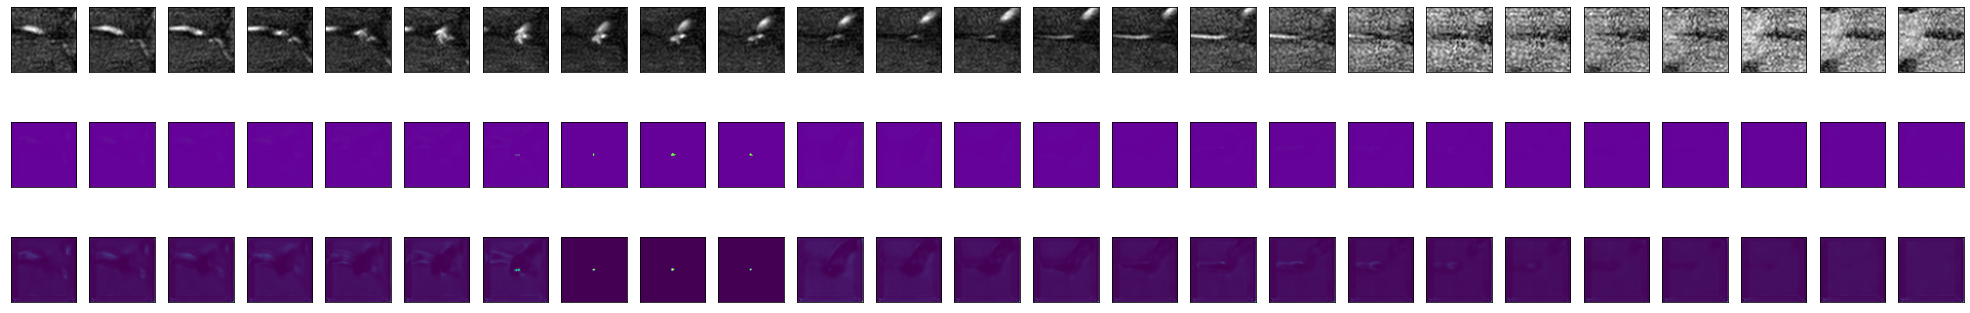

In [ ]:
# The data is displayed as sequential data sets 3D MRI data

n = 25
plt.figure(figsize=(35, 6))
for i in range(24, n+24):
    # display original
    ax = plt.subplot(3, n, i-23)
    plt.imshow(test_img[:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display labels
    ax = plt.subplot(3, n, i-23  + n)
    plt.imshow(ground_truth[:,:,i,0],cmap='winter')
    plt.imshow(test_pred[0,:,:,i,0],cmap='autumn',alpha=0.4)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i-23  + 2*n)
    plt.imshow(np.log(1+test_pred[0,:,:,i,0]))
    #plt.imshow(test_pred[:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
# The data is displayed as sequential data sets 3D MRI data

n = 25
plt.figure(figsize=(35, 6))
for i in range(24, n+24):
    # display original
    ax = plt.subplot(3, n, i-23)
    plt.imshow(test_img[:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display labels
    ax = plt.subplot(3, n, i-23  + n)
    plt.imshow(ground_truth[:,:,i,0],cmap='winter')
    plt.imshow(test_pred[:,:,i],cmap='autumn',alpha=0.4)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i-23  + 2*n)
    plt.imshow(test_pred[:,:,i],cmap='gray')
    #plt.imshow(test_pred[:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Prediction / prediction time augmentation

In [ ]:
#preprocess new data for predictiong

ii=1

img_patche1 = patchify(Aneurisma_data[ii], (64, 64, 64), step=64) 
img_patche = np.reshape(img_patche1, (-1, img_patche1.shape[3], img_patche1.shape[4], img_patche1.shape[5]))
img_patche_before = np.stack((img_patche,)*3, axis=-1)

lbl_patche = patchify(Aneurisma_label[ii], (64, 64, 64), step=64) 
lbl_patche = np.reshape(lbl_patche, (-1, lbl_patche.shape[3], lbl_patche.shape[4], lbl_patche.shape[5]))
lbl_patche_before = np.expand_dims(lbl_patche, axis=4)

img_patche = preprocess_input(img_patche_before)
lbl_patche = preprocess_input(lbl_patche_before)

In [ ]:
# Predict each 3D patch
predicted_patches_n = []
for i in range(img_patche.shape[0]):
    single_patch = img_patche[i,:,:,:]
    single_patch_3ch_input = test_img_input=np.expand_dims(single_patch, 0)
    single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
    predicted_patches_n.append(single_patch_prediction)
predicted_patches_n=np.array(predicted_patches_n)

1/1 [==============================] - 0s 29ms/step


In [ ]:
# Predict each 3D patch for lr
predicted_patches_lr = []
for i in range(img_patche.shape[0]):
    single_patch =  np.fliplr(img_patche[i,:,:,:])
    single_patch_3ch_input = test_img_input=np.expand_dims(single_patch, 0)
    single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
    single_patch_prediction=np.fliplr(single_patch_prediction).astype(np.uint8)
    predicted_patches_lr.append(single_patch_prediction)
predicted_patches_lr=np.array(predicted_patches_lr)

1/1 [==============================] - 0s 39ms/step


In [ ]:
# Predict each 3D patchfor ud
predicted_patches_ud = []
for i in range(img_patche.shape[0]):
    single_patch =  np.flipud(img_patche[i,:,:,:])
    single_patch_3ch_input = test_img_input=np.expand_dims(single_patch, 0)
    single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
    single_patch_prediction=np.flipud(single_patch_prediction).astype(np.uint8)
    predicted_patches_ud.append(single_patch_prediction)
predicted_patches_ud=np.array(predicted_patches_ud)

1/1 [==============================] - 0s 32ms/step


In [ ]:
# Predict each 3D patch  for rot90
predicted_patches_rot90 = []
for i in range(img_patche.shape[0]):
    single_patch =  np.rot90(img_patche[i,:,:,:])
    single_patch_3ch_input = test_img_input=np.expand_dims(single_patch, 0)
    single_patch_prediction = (my_model.predict(single_patch_3ch_input)[0][:,:,:,0]>0.5).astype(np.uint8)
    single_patch_prediction=np.rot90(single_patch_prediction).astype(np.uint8)
    predicted_patches_rot90.append(single_patch_prediction)
predicted_patches_rot90=np.array(predicted_patches_rot90)

1/1 [==============================] - 0s 32ms/step


In [ ]:
#averaging the above predictions
#the aggregation of predictions across transformed versions of a test input using simple average
threshold=0.4
prediciton=(((predicted_patches_n+predicted_patches_lr+predicted_patches_ud+predicted_patches_rot90)/4)>threshold).astype(np.uint8)

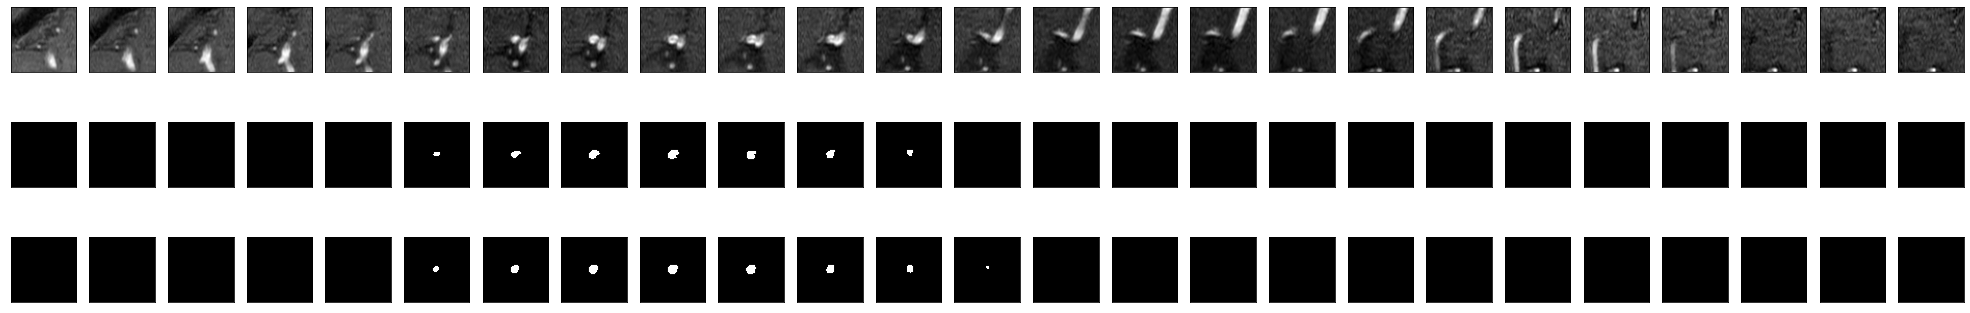

In [ ]:
# The data is displayed as sequential data sets 3D MRI data
n = 25
patch=4
plt.figure(figsize=(35, 6))
for i in range(24, n+24):
    # display original
    ax = plt.subplot(3, n, i-23)
    plt.imshow(img_patche_before[patch][:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display labels
    ax = plt.subplot(3, n, i-23  + n)
    plt.imshow(lbl_patche_before[patch][:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i-23  + 2*n)
    plt.imshow(predicted_patches_n[patch][:,:,i],cmap='gray')
    #plt.imshow(test_pred[:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(prediciton, 
                                        (img_patche1.shape[0], img_patche1.shape[1], img_patche1.shape[2],
                                         img_patche1.shape[3], img_patche1.shape[4], img_patche1.shape[5]) )

In [ ]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, Aneurisma_data[0].shape)
print(reconstructed_image.shape)
     

(192, 192, 64)


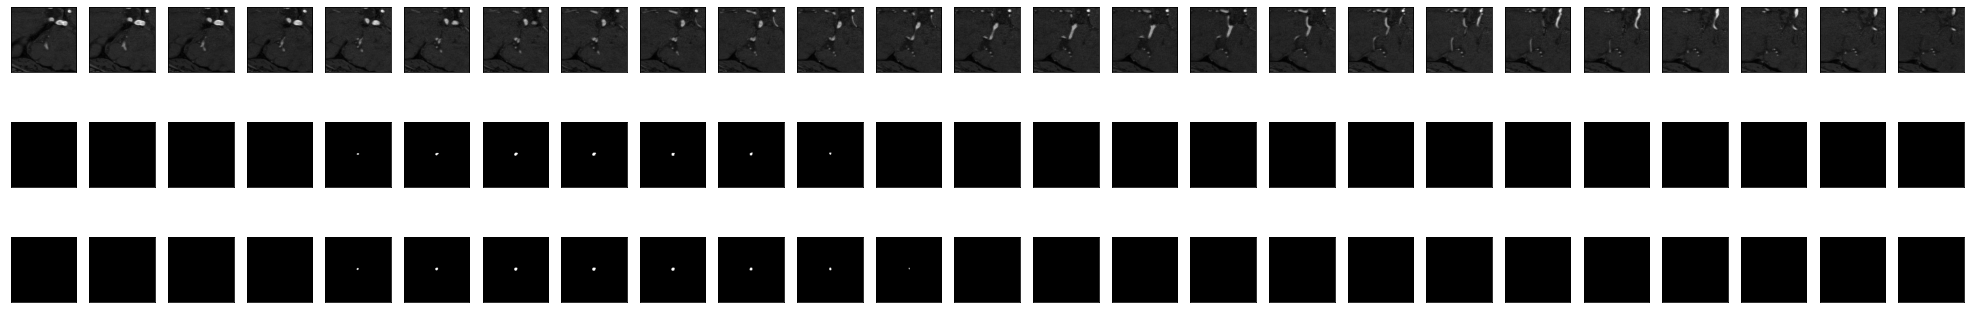

In [ ]:
from pandas import Index
# The data is displayed as sequential data sets 3D MRI data
n = 25
index=25
patch=4
plt.figure(figsize=(35, 6))
for i in range(index, n+index):
    # display original
    ax = plt.subplot(3, n, i-index+1)
    plt.imshow(Aneurisma_data[ii][:,:,i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display labels
    ax = plt.subplot(3, n, i-index+1  + n)
    plt.imshow(Aneurisma_label[ii][:,:,i],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, i-index+1  + 2*n)
    plt.imshow(reconstructed_image[:,:,i],cmap='gray')
    #plt.imshow(test_pred[:,:,i,0],cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [ ]:
from tifffile import imsave
imsave('/content/drive/My Drive/Challenge/challenge_dataset/saved_models/im1.tif', reconstructed_image)